Coding project - Picture enhancement
==============================

For this project it is requested to write a code to automatically enhance a picture.


In order to enhance an image, several functions, each carrying out an action on the image, have been created and will all at the end be combined in the final function of the project: enhancement().

The code written below is applied in this case to the image "etretat.jpg" but is quite general and can improve a priori any image, whether this one is in colour (RGB) or grayscale. For each function, you will see these two cases appear, in the case of a colour image, the 3 channels will always be processed independently whereas in the case of a greyscale image, the image will be processed directly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from skimage.io import imread,imshow,imsave

im = imread('etretat.jpg')
im1 = imread('road.jpg')
im2 = imread('astronaut_noisy.jpg')

In [2]:
def cumul_hist(im):
    cumul_hist = np.zeros((256,))
    c = 0
    for v in range (256):
        c += (im==v).sum()
        cumul_hist[v] = c
    cumul_hist /= cumul_hist.max()
    return cumul_hist

The first processing step is designed to reduce noise which is done by applying a median filter to the image. The imported skimage median filter is used for this purpose with as structuring element a disk of a size chosen by the user. The disk was selected here because, although it tends to blur the image more than the square, it allows noise to be removed very effectively even when its size is quite small (where the square sometimes leaves noise). The choice of size is left to the user in order to give him more freedom in modifying his image, but if a size should have been defined univocally, it should have been chosen small enough (2 for example) in order to remove the noise where necessary but not to modify too much an image which does not contain a lot of noise.

In [3]:
from skimage.filters.rank import median
from skimage.morphology import disk

def noise_reduction(im, size):
    im_out = im.copy()
    if len(im.shape)==3:
        for i in range(3):
            im_out[:,:,i] = median(im[:,:,i], disk(size))
        return(im_out)
    elif len(im.shape)<3:
        return(median(im, disk(size)))
    else:
        print("A color or greyscale image is expeceted")
        exit(1)

To further improve the image, we can apply the auto-level to it to increase the contrast. This is done by modifying the image to use all the levels in its dynamic range. To do this, we will apply a look-up table to the image which will set all pixels below a certain Tmin value to 0, all pixels above a certain Tmax value to 255 and stretch the histogram of pixels with values between Tmin and Tmax to cover all possible values. The Tmin and Tmax bounds are calculated from the cumulative histogram of the image so that only 2% of the pixels at 0 and 2% of the pixels at 255. 

In [4]:
def auto_leveling(im):
    if len(im.shape)==3:
        h1 = cumul_hist(im[:,:,0])
        h2 = cumul_hist(im[:,:,1])
        h3 = cumul_hist(im[:,:,2])
    
        for v in range(256):
            if h1[v] > 0.02: break
        T_min1 = v
        for v in range(256):
            if h2[v] > 0.02: break
        T_min2 = v
        for v in range(256):
            if h3[v] > 0.02: break
        T_min3 = v

        for v in range(256):
            if h1[255-v] < 0.98:break
        T_max1 = (255-v)+1
        for v in range(256):
            if h2[255-v] < 0.98:break
        T_max2 = (255-v)+1
        for v in range(256):
            if h3[255-v] < 0.98:break
        T_max3 = (255-v)+1

        lut1 = np.arange(256)
        lut2 = np.arange(256)
        lut3 = np.arange(256)
        lut1[:T_min1] = 0
        lut2[:T_min2] = 0
        lut3[:T_min3] = 0
        lut1[T_max1:] = 255
        lut2[T_max2:] = 255
        lut3[T_max3:] = 255
        lut1[T_min1:T_max1] = (255/(T_max1-T_min1))*(lut1[T_min1:T_max1] - T_min1)
        lut2[T_min2:T_max2] = (255/(T_max2-T_min2))*(lut2[T_min2:T_max2] - T_min2)
        lut3[T_min3:T_max3] = (255/(T_max3-T_min3))*(lut3[T_min3:T_max3] - T_min3)
    
        im_fin = im.copy()
        im_fin[:,:,0] = lut1[im[:,:,0]]
        im_fin[:,:,1] = lut2[im[:,:,1]]
        im_fin[:,:,2] = lut3[im[:,:,2]]
        return(im_fin)
    else:
        h = cumul_hist(im)
        for v in range(256):
            if h[v] > 0.02: break
        T_min = v
        for v in range(256):
            if h[255-v] < 0.98:break
        T_max = (255-v)+1
        
        lut = np.arange(256)
        lut[:T_min] = 0
        lut[T_max:] = 255
        lut[T_min:T_max] = (255/(T_max-T_min))*(lut[T_min:T_max] - T_min)
        return(lut[im])
    return(lut[im])

Another thing we could do is apply a gamma correction to the image in order to further improve the contrast. The level transform is given by :

$$g_{out} = A \: g_{in}^{\gamma}$$ where $$ A = 255^{(1-\gamma)}$$

We will therefore create a look-up table corresponding to this transformation and apply it to the image. 
Depending on the gamma value, the low ($\gamma < 1$) or high ($\gamma > 1$) levels of the image will be contrasted. Based on the histogram of the image, we will determine which gamma value should be used. If more than 50% of the pixels are in the low range, gamma will be set to 0.6, while if 50% or more of the pixels are in the high range, gamma will be set to 1.7.

In [5]:
def gamma_correction(im):
    if len(im.shape)==3:
        h1 = cumul_hist(im[:,:,0])
        h2 = cumul_hist(im[:,:,1])
        h3 = cumul_hist(im[:,:,2])
        
        for v in range(256):
            if h1[v] > 0.5: break
        fifty1 = v
        for v in range(256):
            if h2[v] > 0.5: break
        fifty2 = v
        for v in range(256):
            if h3[v] > 0.5: break
        fifty3 = v
        
        if fifty1 >= 127:
            gamma1 = 1.7
        else:
            gamma1 = 0.6
        if fifty2 >= 127:
            gamma2 = 1.7
        else:
            gamma2 = 0.6
        if fifty3 >= 127:
            gamma3 = 1.7
        else:
            gamma3 = 0.6
        
        lut1 = np.power(np.arange(0,256),gamma1) * np.power(255,1-gamma1)
        lut2 = np.power(np.arange(0,256),gamma2) * np.power(255,1-gamma2)
        lut3 = np.power(np.arange(0,256),gamma3) * np.power(255,1-gamma3)
        
        im_fin = im.copy()
        im_fin[:,:,0] = lut1[im[:,:,0]]
        im_fin[:,:,1] = lut2[im[:,:,1]]
        im_fin[:,:,2] = lut3[im[:,:,2]]
        return(im_fin)
    
    else:
        h = cumul_hist(im)
        for v in range(256):
            if h[v] > 0.5: break
        fifty = v
        if fifty >= 127:
            gamma = 1.7
        else:
            gamma = 0.6
    
        lut = np.power(np.arange(0,256),gamma) * np.power(255,1-gamma)
        return(lut[im])

We will now apply equalisation to our image, i.e. we will try to make its histogram as flat as possible. This will allow us, once again, to increase the contrast. For this, we are going to use as look-up table, the cumulative histogram of the image (multiplied by 255 because the cumulative histogram has its values between 0 and 1).

In [6]:
def equalization(im):
    if len(im.shape)==3:
        h1 = cumul_hist(im[:,:,0])
        h2 = cumul_hist(im[:,:,1])
        h3 = cumul_hist(im[:,:,2])
        lut1 = (255*h1).astype('uint8')
        lut2 = (255*h2).astype('uint8')
        lut3 = (255*h3).astype('uint8')
        im_fin = im.copy()
        im_fin[:,:,0] = lut1[im[:,:,0]]
        im_fin[:,:,1] = lut2[im[:,:,1]]
        im_fin[:,:,2] = lut3[im[:,:,2]]
        return(im_fin)
    else:
        h = cumul_hist(im)
        lut = (255*h).astype('uint8')
        return(lut[im])

Finally, we will increase the colour saturation of the image to make it stronger (this step is never called if the image provided is in grayscale). This is done by working with the hsv form of the image in which all pixels will see their saturation increase by a certain value (if not already maximum). The image is then converted back to RGB for display.

In [7]:
from skimage.color import rgb2hsv, hsv2rgb

def saturation(im):
    hsv = rgb2hsv(im)
    for y in range(hsv.shape[0]):
        for x in range(hsv.shape[1]):
            if(hsv[y,x,1] < 0.9):
                hsv[y,x,1] += 0.1
            else:
                hsv[y,x,1] = 1
    return(hsv2rgb(hsv))

Now here is the main function, allowing to enhance an image. It consists of the concatenation of the methods created above. It has been decided here that the user can choose to either improve his image via auto level and equalization or via gamma correction by specifying a value for gamma (True or False) as a parameter in the function.

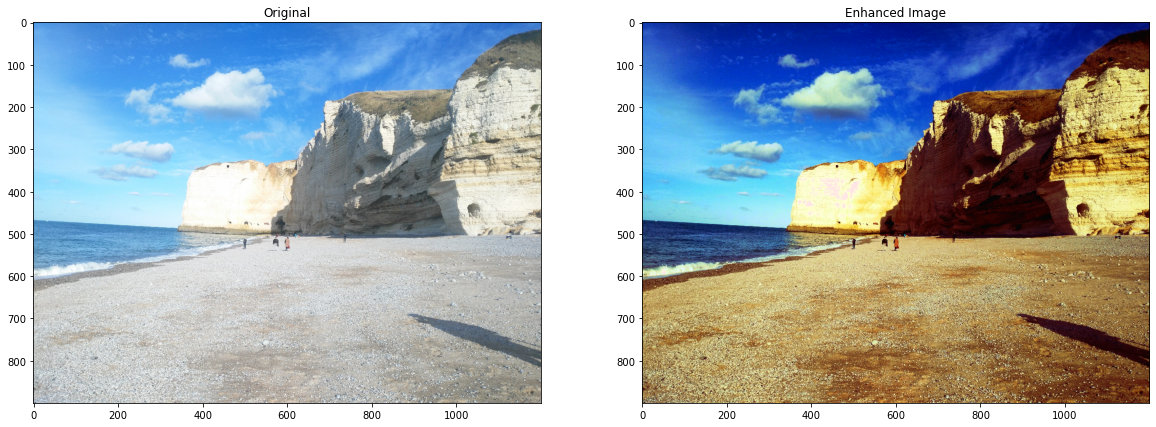

In [8]:
def enhancement(im, size_noise, gamma):
    im1 = noise_reduction(im, size_noise)
    if gamma==1:
        im2 = gamma_correction(im1)
        im3 = im2.astype('uint8')
    else:
        im2 = auto_leveling(im1)
        im3 = equalization(im2)
    if len(im.shape)==3:
        return(saturation(im3))
    else:
        return im3

im_final = enhancement(im, 0, 0)
imsave('imageEnhanced.jpg',(im_final*255).astype('uint8'))

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(im, cmap=cm.gray)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(im_final, cmap=cm.gray)
plt.title('Enhanced Image')
plt.show()